# Stream Physically Correct SmartSPIM Images

In this notebook we demonstrate how to use tools in `aind_ccf_alignment_experiments` to compose SmartSPIM metadata from multiple sources and stream physical image subregions at any SmartSPIM level.

Relevant data standards may be found here:
- [Open Microscopy Environment "Zarr" Next Generation File Format (OME-Zarr NGFF)](https://github.com/ome/ngff)
- [Allen Institute for Neural Dynamics acquisition scheme](https://github.com/AllenNeuralDynamics/aind-data-schema/blob/main/src/aind_data_schema/imaging/acquisition.py)
- [ITK Image](https://itk.org/Doxygen/html/classitk_1_1Image.html)


In [1]:
import itk
import matplotlib.pyplot as plt
import numpy as np
import s3fs

import sys

sys.path.append("../src")
from aind_ccf_alignment_experiments.image import physical_to_image_region
from aind_ccf_alignment_experiments.smartspim import (
    make_smartspim_stream_reader,
)

In [2]:
SMARTSPIM_SAMPLE_BUCKET = r"s3://aind-open-data/SmartSPIM_652506_2023-01-09_10-18-12_stitched_2023-02-09_17-23-28/processed/OMEZarr/Ex_561_Em_593.zarr"
NUM_SMARTSPIM_LEVELS = 5

## Read Metadata

SmartSPIM metadata must be composed from two sources:
- Stitched SmartSPIM data is available in OME-Zarr NGFF format with multiple resolutions and well-defined size, spacing, and translation at each resolution level. OME-Zarr v0.4 does not encode direction.
- SmartSPIM acquisition headers encode direction.

Here we compose and display SmartSPIM image header information at a few different levels. We do not yet read SmartSPIM voxel data.

Note that ITK image access convention is reversed from NumPy access convention. An ITK image with size [1,2,3] is equivalent in memory storage to a NumPy array with size [3,2,1].

In [3]:
def summarize_image_metadata(image: itk.Image):
    """Summarize ITK image metadata"""
    print(
        f"Available image array index,size: {image.GetLargestPossibleRegion()}"
    )
    print(f"Buffered image array index,size: {image.GetBufferedRegion()}")
    print(f"Requested image array index,size: {image.GetRequestedRegion()}")
    print(f"Image spacing: {itk.spacing(image)}")
    print(f"Image origin: {itk.origin(image)}")
    print(f"Image direction: {image.GetDirection()}")
    print("\n")

In [4]:
for smartspim_level in range(NUM_SMARTSPIM_LEVELS):
    smartspim_reader = make_smartspim_stream_reader(
        SMARTSPIM_SAMPLE_BUCKET, smartspim_level
    )
    summarize_image_metadata(smartspim_reader.GetOutput())

Available image array index,size: itkImageRegion3([0, 0, 0], [7433, 10272, 3700])
Buffered image array index,size: itkImageRegion3([0, 0, 0], [0, 0, 0])
Requested image array index,size: itkImageRegion3([0, 0, 0], [7433, 10272, 3700])
Image spacing: itkVectorD3 ([0.0018, 0.0018, 0.002])
Image origin: itkPointD3 ([13.3776, 18.4878, 7.398])
Image direction: itkMatrixD33 ([[-1.0, 0.0, 0.0], [0.0, -1.0, 0.0], [0.0, 0.0, -1.0]])


Available image array index,size: itkImageRegion3([0, 0, 0], [3716, 5136, 1850])
Buffered image array index,size: itkImageRegion3([0, 0, 0], [0, 0, 0])
Requested image array index,size: itkImageRegion3([0, 0, 0], [3716, 5136, 1850])
Image spacing: itkVectorD3 ([0.0036, 0.0036, 0.004])
Image origin: itkPointD3 ([13.374, 18.486, 7.396])
Image direction: itkMatrixD33 ([[-1.0, 0.0, 0.0], [0.0, -1.0, 0.0], [0.0, 0.0, -1.0]])


Available image array index,size: itkImageRegion3([0, 0, 0], [1858, 2568, 925])
Buffered image array index,size: itkImageRegion3([0, 0, 0], [0, 

## Stream a Voxel Region

Due to the size of SmartSPIM data we often want to work with a subregion of available data. We can explicitly request image subregions to stream from the cloud into local memory.

SmartSPIM data is stored in [Zarr](https://zarr.readthedocs.io/en/stable/getting_started.html) chunks on Amazon AWS S3. [`itk.IOOMEZarrImageIO`](https://github.com/InsightSoftwareConsortium/ITKIOOMEZarrNGFF) abstracts image data retrieval with backing from a [fork](https://github.com/insightsoftwareconsortium/tensorstore) of Google's [`Tensorstore`](https://github.com/google/tensorstore) interface such that data of arbitrary sizes may be streamed. Performance may be improved by streaming regions approximating upstream chunk sizes.

In our example we use the same requested region across each level to demonstrate ITK streaming conventions. Directly requesting voxel subregions like this is often not particularly useful because each subregion represents a different position and size across SmartSPIM levels. In the next section we present a more useful approach using physical subregions.

In [5]:
# Set up an arbitrary requested region.
# Our region will start at voxel index [10, 20, 30] and represent a 50x50x50 array.
#
# Recall that ITK and NumPy access conventions are reversed. This is equivalent to NumPy access as follows:
# arr[30:80,20:70,10:60]

requested_region = itk.ImageRegion[3]()
requested_region.SetIndex([10, 20, 30])
requested_region.SetSize([50] * 3)

In [6]:
# Stream the voxel region
for smartspim_level in range(NUM_SMARTSPIM_LEVELS):
    smartspim_reader = make_smartspim_stream_reader(
        SMARTSPIM_SAMPLE_BUCKET, smartspim_level
    )
    smartspim_reader.GetOutput().SetRequestedRegion(requested_region)

    # Allocate local memory and fetch data from the cloud
    smartspim_reader.Update()

    summarize_image_metadata(smartspim_reader.GetOutput())

Available image array index,size: itkImageRegion3([0, 0, 0], [7433, 10272, 3700])
Buffered image array index,size: itkImageRegion3([10, 20, 30], [50, 50, 50])
Requested image array index,size: itkImageRegion3([10, 20, 30], [50, 50, 50])
Image spacing: itkVectorD3 ([0.0018, 0.0018, 0.002])
Image origin: itkPointD3 ([13.3776, 18.4878, 7.398])
Image direction: itkMatrixD33 ([[-1.0, 0.0, 0.0], [0.0, -1.0, 0.0], [0.0, 0.0, -1.0]])


Available image array index,size: itkImageRegion3([0, 0, 0], [3716, 5136, 1850])
Buffered image array index,size: itkImageRegion3([10, 20, 30], [50, 50, 50])
Requested image array index,size: itkImageRegion3([10, 20, 30], [50, 50, 50])
Image spacing: itkVectorD3 ([0.0036, 0.0036, 0.004])
Image origin: itkPointD3 ([13.374, 18.486, 7.396])
Image direction: itkMatrixD33 ([[-1.0, 0.0, 0.0], [0.0, -1.0, 0.0], [0.0, 0.0, -1.0]])


Available image array index,size: itkImageRegion3([0, 0, 0], [1858, 2568, 925])
Buffered image array index,size: itkImageRegion3([10, 20, 3

## Stream a Physical Region

Rather than directly requesting image voxel regions, it is often useful to work primarily in the physical domain and then translate requests to the voxel domain only as necessary. Through image metadata abstractions we can request different voxel array regions across image levels that represent the same region in physical space.

In the example below we stream subimages representing an arbitrary 1mm^3 subvolume at different SmartSPIM levels. The size of the representative voxel array varies significantly in magnitude with level:
- Level 0: approximately 500^3 voxels
- Level 4: approximately 30^3 voxels

In [7]:
# Set up an arbitrary physical region represented by two point bounds
requested_physical_region_mm = np.array([[1.0, 1.0, 1.0], [2.0, 2.0, 2.0]])

In [8]:
# Stream the physical region
for smartspim_level in range(NUM_SMARTSPIM_LEVELS):
    smartspim_reader = make_smartspim_stream_reader(
        SMARTSPIM_SAMPLE_BUCKET, smartspim_level
    )
    smartspim_reader.GetOutput().SetRequestedRegion(
        physical_to_image_region(
            physical_region=requested_physical_region_mm,
            ref_image=smartspim_reader.GetOutput(),
        )
    )
    smartspim_reader.Update()
    summarize_image_metadata(smartspim_reader.GetOutput())

Available image array index,size: itkImageRegion3([0, 0, 0], [7433, 10272, 3700])
Buffered image array index,size: itkImageRegion3([6321, 9160, 2699], [556, 556, 501])
Requested image array index,size: itkImageRegion3([6321, 9160, 2699], [556, 556, 501])
Image spacing: itkVectorD3 ([0.0018, 0.0018, 0.002])
Image origin: itkPointD3 ([13.3776, 18.4878, 7.398])
Image direction: itkMatrixD33 ([[-1.0, 0.0, 0.0], [0.0, -1.0, 0.0], [0.0, 0.0, -1.0]])


Available image array index,size: itkImageRegion3([0, 0, 0], [3716, 5136, 1850])
Buffered image array index,size: itkImageRegion3([3159, 4579, 1349], [279, 279, 251])
Requested image array index,size: itkImageRegion3([3159, 4579, 1349], [279, 279, 251])
Image spacing: itkVectorD3 ([0.0036, 0.0036, 0.004])
Image origin: itkPointD3 ([13.374, 18.486, 7.396])
Image direction: itkMatrixD33 ([[-1.0, 0.0, 0.0], [0.0, -1.0, 0.0], [0.0, 0.0, -1.0]])


Available image array index,size: itkImageRegion3([0, 0, 0], [1858, 2568, 925])
Buffered image array in

## Visualize voxel array with `matplotlib`

We use `matplotlib` to directly visualize slices of the stream voxel array without concern for image metadata.

In [ ]:
import matplotlib.pyplot as plt

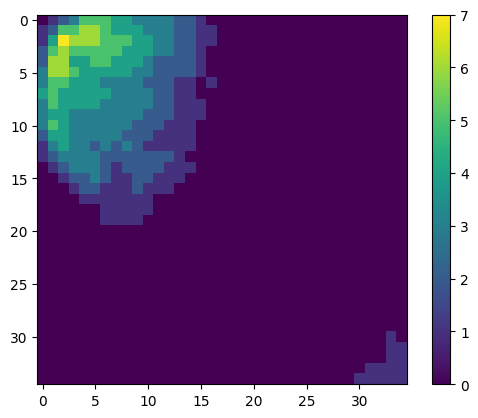

In [10]:
smartspim_level = 4
smartspim_reader = make_smartspim_stream_reader(
    SMARTSPIM_SAMPLE_BUCKET, smartspim_level
)
smartspim_reader.GetOutput().SetRequestedRegion(
    physical_to_image_region(
        physical_region=requested_physical_region_mm,
        ref_image=smartspim_reader.GetOutput(),
    )
)
smartspim_reader.Update()

subimage = itk.extract_image_filter(
    smartspim_reader.GetOutput(),
    extraction_region=smartspim_reader.GetOutput().GetBufferedRegion(),
)

plt.title("SmartSPIM Level 4 (Lowest Resolution)")
plt.imshow(subimage[0, :, :])
plt.colorbar()
plt.show()

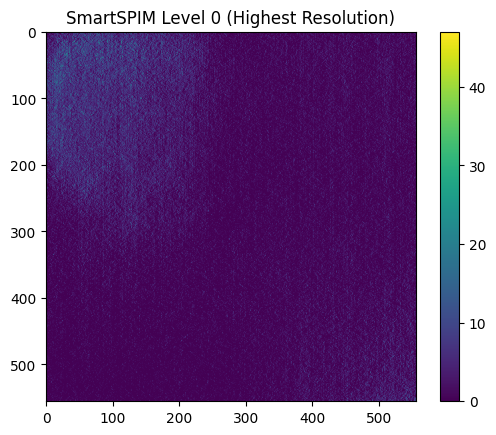

In [11]:
smartspim_level = 0
smartspim_reader = make_smartspim_stream_reader(
    SMARTSPIM_SAMPLE_BUCKET, smartspim_level
)
smartspim_reader.GetOutput().SetRequestedRegion(
    physical_to_image_region(
        physical_region=requested_physical_region_mm,
        ref_image=smartspim_reader.GetOutput(),
    )
)
smartspim_reader.Update()

subimage = itk.extract_image_filter(
    smartspim_reader.GetOutput(),
    extraction_region=smartspim_reader.GetOutput().GetBufferedRegion(),
)

plt.title("SmartSPIM Level 0 (Highest Resolution)")
plt.imshow(subimage[30, :, :])
plt.colorbar()
plt.show()